# CNN image classification models incorporated with explainability algorithms

In [1]:
import os
import keras
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report                      
import tensorflow as tf
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.applications import inception_v3 as inc_net              
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from keras.optimizers import Adam
from keras.callbacks import TensorBoard
from skimage.io import imread                                                
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from aix360.algorithms.protodash import ProtodashExplainer
import lime
from lime import lime_image
import shap
import warnings
warnings.filterwarnings('ignore')

### For image recognition I used keras InceptionV3 model, a convolutional neural network architecture pre-trained upon ImageNet dataset. 
### ImageNet contains approx. 1.2 millions samples, each from one of the 1000 categories such as goldfish, peacock, coffee mug, desk etc

1/1 [==============================] - 6s 6s/step
('n01748264', 'Indian_cobra', 0.96247184)
('n03527444', 'holster', 0.0013415064)
('n01740131', 'night_snake', 0.00078915944)
('n01735189', 'garter_snake', 0.00070355827)
('n04153751', 'screw', 0.0006609139)


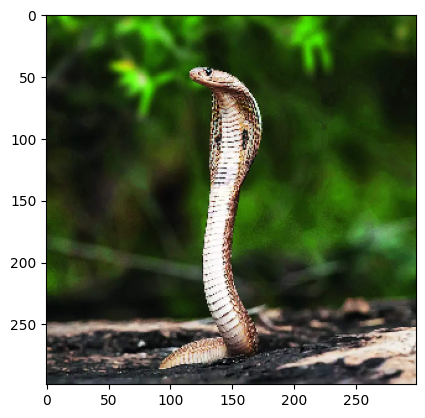

In [3]:
model = inc_net.InceptionV3()

# Function to load an image from system and preprocess it according to model requirements
def transform_img_fn(path_list):                      
    out = []
    for img_path in path_list:                                     
        img = image.load_img(img_path, target_size=(299, 299))        
        x = image.img_to_array(img)                                  
        x = np.expand_dims(x, axis=0)                               
        x = inc_net.preprocess_input(x)                             
        out.append(x)                                              
    return np.vstack(out) 

#Taking an example image from system and top 5 predictions for it
images = transform_img_fn([os.path.join('Lime/data','snake.jpg')])
plt.imshow(images[0] / 2 + 0.5)                                                  
preds = model.predict(images)
for x in decode_predictions(preds)[0]:                                   
    print(x)

## Model Explanability by LIME –

In [6]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(images[0].astype('double'), model.predict, top_labels=5, hide_color=0, num_samples=1000)    

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 9s 9s/step


### Explanation for the top class

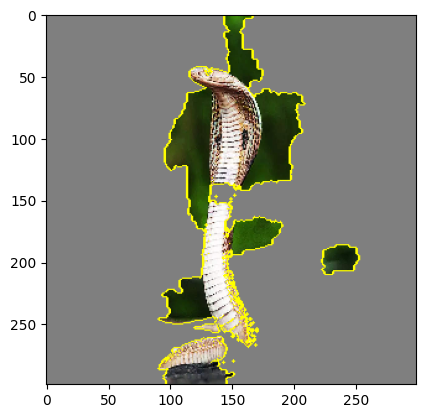

In [7]:
#Generates visualization that highlights the most imp regions in image based on LIME explanation.

from skimage.segmentation import mark_boundaries
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

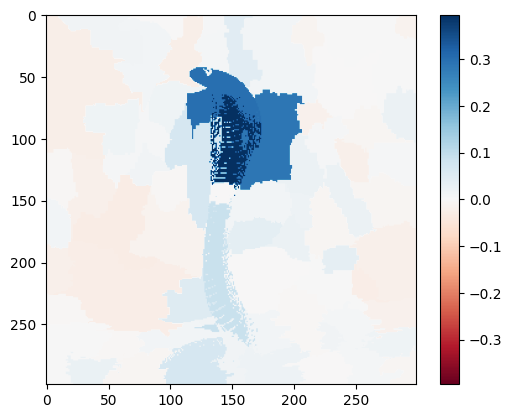

In [9]:
# Heatmap visualization

top =  explanation.top_labels[0]
dict_heatmap = dict(explanation.local_exp[top])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

## Model Explanability by SHAP –

In [10]:
# Loading FASHION-MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
x_train.shape

(60000, 28, 28)

In [11]:
# Reshape(expand dimensions) and Normalization
x_train = x_train.reshape(60000, 28, 28, 1).astype("float32") / 255
x_test = x_test.reshape(10000, 28, 28, 1).astype("float32") / 255

#### Exploratory Data Analysis (EDA) - Dataset consists of 70,000 images divided into 60,000 training and rest for testing. 
#### Each sample is a grayscale image of dimensions 28x28 pixels. Every sample corresponds to one of the 10 fashion categories. 

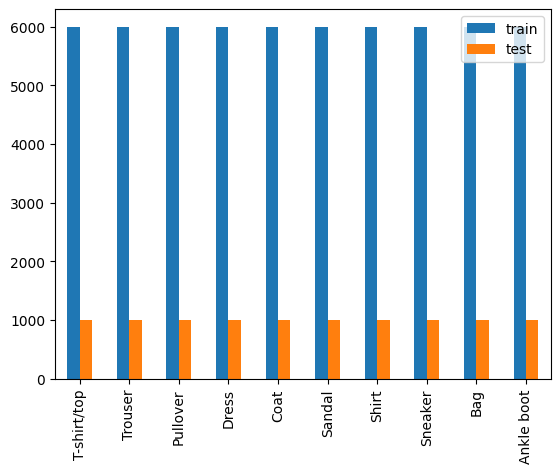

In [12]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat','Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
_, train_counts = np.unique(y_train, return_counts=True)
_, test_counts = np.unique(y_test, return_counts=True)
pd.DataFrame({'train': train_counts,'test': test_counts},index=class_names).plot.bar()
plt.show()

## Build Model

In [13]:
# CNN model architecture composed of a single convolutional and maxpooling layers pair connected to a dense layer with 256 units 
# and the output layer with 10 units for categories.

inputs = keras.Input(shape=(28, 28, 1))
x = keras.layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = keras.layers.MaxPooling2D((2, 2))(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(256, activation='relu')(x)
outputs = keras.layers.Dense(10, activation='softmax')(x)

# Create the model with the corresponding inputs and outputs
model = keras.Model(inputs=inputs, outputs=outputs, name="CNN")

# Compile the model
model.compile(
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      optimizer=keras.optimizers.Adam(),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
  )

# Train model
history=model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

Epoch 1/5
1875/1875 [==============================] - 164s 86ms/step - loss: 0.3870 - sparse_categorical_accuracy: 0.8616 - val_loss: 0.3238 - val_sparse_categorical_accuracy: 0.8841
Epoch 2/5
1875/1875 [==============================] - 146s 78ms/step - loss: 0.2609 - sparse_categorical_accuracy: 0.9048 - val_loss: 0.2757 - val_sparse_categorical_accuracy: 0.8988
Epoch 3/5
1875/1875 [==============================] - 137s 73ms/step - loss: 0.2129 - sparse_categorical_accuracy: 0.9205 - val_loss: 0.2678 - val_sparse_categorical_accuracy: 0.9054
Epoch 4/5
1875/1875 [==============================] - 156s 83ms/step - loss: 0.1775 - sparse_categorical_accuracy: 0.9333 - val_loss: 0.2437 - val_sparse_categorical_accuracy: 0.9142
Epoch 5/5
1875/1875 [==============================] - 182s 97ms/step - loss: 0.1476 - sparse_categorical_accuracy: 0.9464 - val_loss: 0.2573 - val_sparse_categorical_accuracy: 0.9106


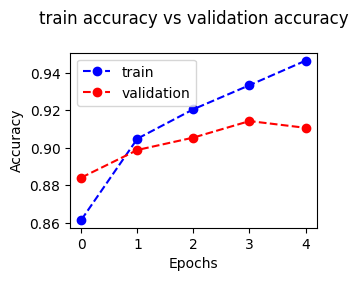

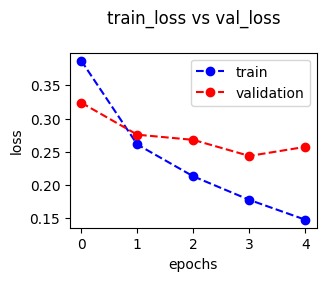

In [14]:
# Plot loss function
  
fig = plt.figure(figsize=(7,5))
plt.subplot(222)
plt.plot(history.history['sparse_categorical_accuracy'],'bo--', label = "train")
plt.plot(history.history['val_sparse_categorical_accuracy'], 'ro--', label = "validation")
plt.title("train accuracy vs validation accuracy\n")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()

# Plot accuracy function
  
fig = plt.figure(figsize=(7,5))
plt.subplot(222)
plt.plot(history.history['loss'],'bo--', label = "train")
plt.plot(history.history['val_loss'], 'ro--', label = "validation")
plt.title("train_loss vs val_loss\n")
plt.ylabel("loss")
plt.xlabel("epochs")
plt.legend()
plt.show()

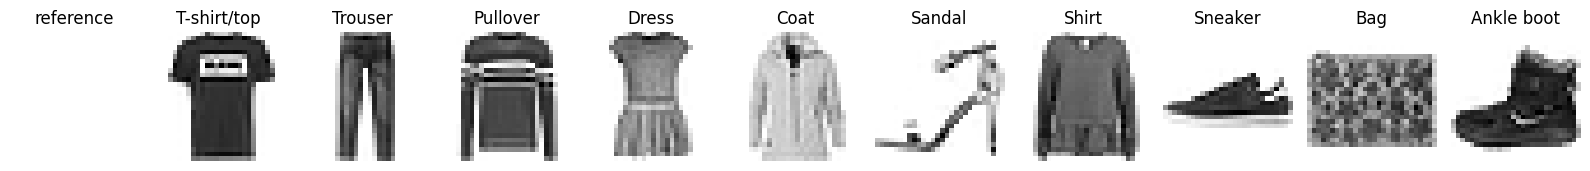

In [15]:
# Save an example for each category in a dict
images_dict = dict()
for i, l in enumerate(y_train):
  if len(images_dict)==10:
    break
  if l not in images_dict.keys():
    images_dict[l] = x_train[i].reshape((28, 28))

# Function to plot images
def plot_categories(images):
  fig, axes = plt.subplots(1, 11, figsize=(16, 15))
  axes = axes.flatten()
  
  # Plot an empty canvas
  ax = axes[0]
  dummy_array = np.array([[[0, 0, 0, 0]]], dtype='uint8')
  ax.set_title("reference")
  ax.set_axis_off()
  ax.imshow(dummy_array, interpolation='nearest')

  # Plot an image for every category
  for k,v in images.items():
    ax = axes[k+1]
    ax.imshow(v, cmap=plt.cm.binary)
    ax.set_title(f"{class_names[k]}")
    ax.set_axis_off()

  plt.tight_layout()
  plt.show()
plot_categories(images_dict)

### DeepExplainer class in the SHAP library is specifically designed for explaining  deep learning model predictions. To compute SHAP values, a background dataset is required. It samples instances from this background dataset and observes how the model's output changes when specific features are included or excluded. This approach is model-agnostic.

In [16]:
# Take a random sample of 5000 training images
background = x_train[np.random.choice(x_train.shape[0], 4000, replace=False)]

# Use DeepExplainer to explain predictions of the model
e = shap.DeepExplainer(model, background)

#### Extracting 10 samples from test data each pertaining to different category and sorting according to their predicted classes 

In [17]:
# Save an example of each class from the test set
x_test_dict = dict()
for i, l in enumerate(y_test):
  if len(x_test_dict)==10:
    break
  if l not in x_test_dict.keys():
    x_test_dict[l] = x_test[i]

# Convert to list preserving order of classes
x_test_each_class = [x_test_dict[i] for i in sorted(x_test_dict)]

# Convert to tensor
x_test_each_class = np.asarray(x_test_each_class)

# Print shape of tensor
print(f"x_test_each_class tensor has shape: {x_test_each_class.shape}")

x_test_each_class tensor has shape: (10, 28, 28, 1)


In [26]:
# Compute predictions
predictions = model.predict(x_test_each_class)
# Apply argmax to get predicted class
np.argmax(predictions, axis=1)

1/1 [==============================] - 0s 479ms/step


array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

In [27]:
# Compute shap values using DeepExplainer instance
shap_values = e.shap_values(x_test_each_class)

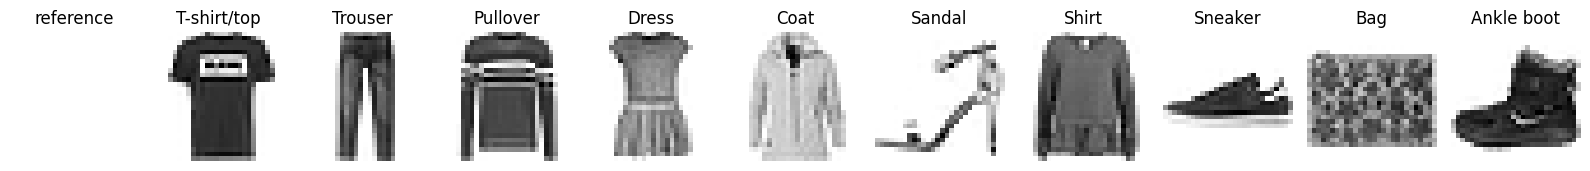

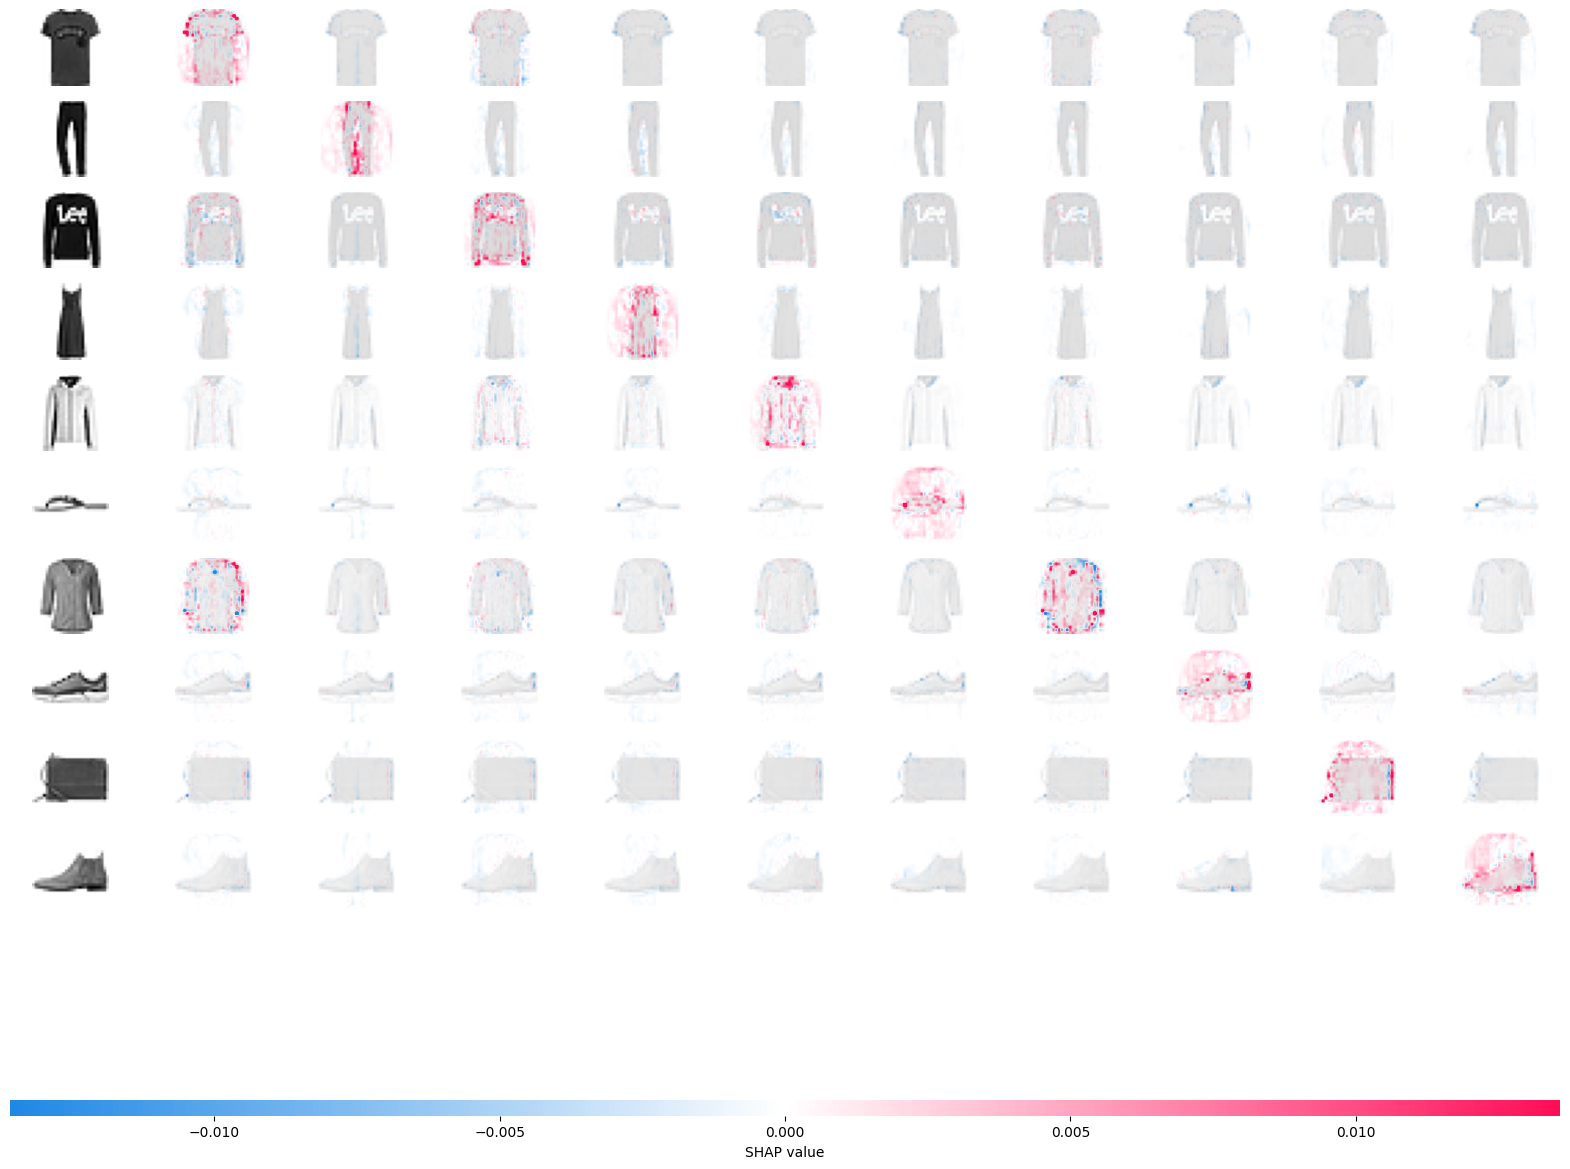

In [28]:
# Plot reference column
plot_categories(images_dict)
print()
# Plot shap values
shap.image_plot(shap_values, -x_test_each_class)

### SHAPley values showed that the model predicted each class sample with the correct pixels in consideration. Red highlighted pixels is positively contributing to the corresponding category while blue pixels shows negative correlation.

## Model Explanability by Protodash –

In [29]:
# Load MNIST dataset consisting of handwritten digit images. It is a collection of 70000 grayscale images divided into training 60000 images and 
# 10000 testing images, each of dimensions 28x28 pixels. The digits range from 0 to 9.
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
print(train_images.shape )
print(test_images.shape)

(60000, 28, 28)
(10000, 28, 28)


### Exploratory Data Analysis (EDA)

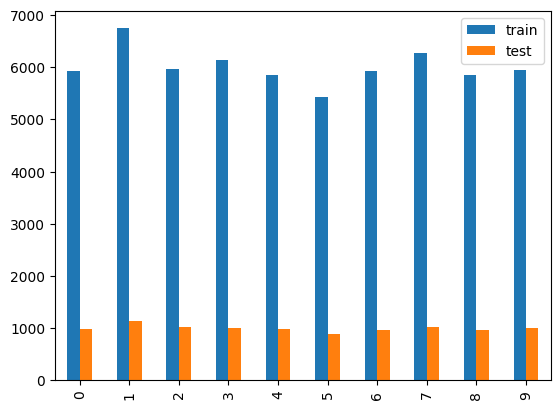

In [30]:
classes = [x for x in range(10)]
_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,'test': test_counts},index=classes).plot.bar()
plt.show()

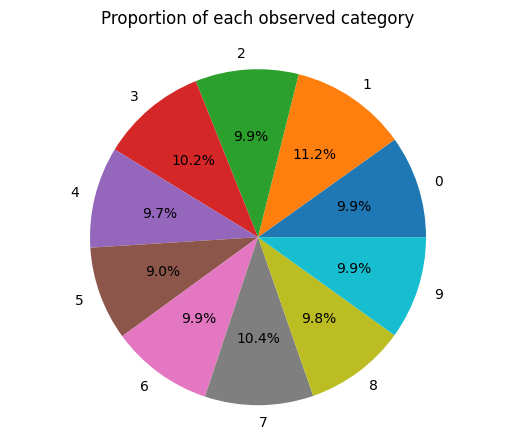

In [31]:
plt.pie(train_counts,labels=classes,autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category\n')
plt.show()

### Data Preprocessing -

In [32]:
# Normalization, Rounding & Reshaping
train_images=train_images.astype('float32') / 255
train_images = np.round(train_images, 5) 
train_images2d=train_images.reshape(-1, 28*28)
train_images2d.shape

(60000, 784)

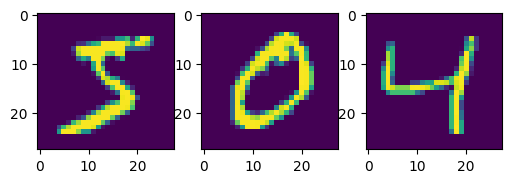

In [34]:
fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(6,6))
ax1.imshow(train_images[0])
ax2.imshow(train_images[1])
ax3.imshow(train_images[2])
plt.show()

### Before feeding the dataset to Protodash algorithm, one hot encoding is required. It is a technique used to convert data into a binary matrix format. ProtoDash requires three key inputs: the dataset you want to explain, the dataset you want to select prototypical explanations from, and the number of prototypes to select.

In [35]:
explainer = ProtodashExplainer()
onehot_encoder = OneHotEncoder(sparse=False)
onehot_encoded = onehot_encoder.fit_transform(train_images2d[:1700,:])

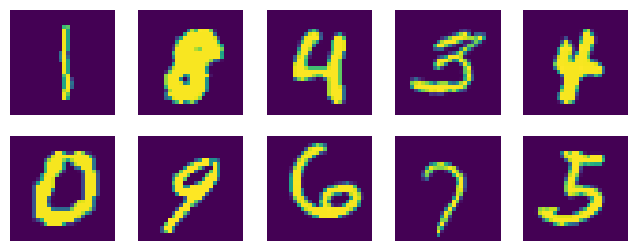

In [36]:
(W, S, _) = explainer.explain(onehot_encoded,onehot_encoded, m=10) 
fig, axes = plt.subplots(2, 5, figsize=(8, 3))
for i, idx in enumerate(S):
    if i < 12:
        ax = axes.flat[i]
        ax.imshow(train_images[idx])
        ax.axis('off')  
plt.show()

#### Protodash algorithm was able to extract the underlying distribution in the MNIST dataset and displayed required prototypes. 
#### Additionally, it can display prototypes of a sample image :-


In [37]:
#Taking first image (5) as sample

sample=onehot_encoded[0]
sample=sample.reshape(1, sample.shape[0])
(W, S, _) = explainer.explain(sample,onehot_encoded, m=3) 
W = np.around(W/np.sum(W), 3) 

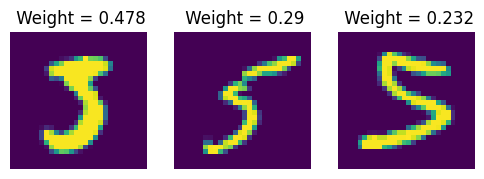

In [38]:
fig, axes = plt.subplots(1, 3, figsize=(6, 3))
for i, idx in enumerate(S):
    if i < 5:
        ax = axes.flat[i]
        ax.imshow(train_images[idx])
        ax.set_title(f" Weight = {W[i]}")
        ax.axis('off') 
plt.show()

#### As we fed sample image-5 into the algorithm, it extracted the similar images with corresponding weights.